Imports First

In [1]:
# !pip install pandas matplotlib numpy statsmodels scipy seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')

Create Dataset

In [2]:
np.random.seed(42)
dates = pd.date_range('1900-01-01', periods=1090, freq='W')
# Create seasonal pattern with trend and noise
seasonal_pattern = 10 * np.sin(2 * np.pi * np.arange(1090) / 52)
trend = 0.01 * np.arange(1090)
noise = np.random.normal(0, 2, 1090)
temp_values = 15 + seasonal_pattern + trend + noise

temp_df = pd.DataFrame({
    'date': dates,
    'temp': temp_values
})
temp_df.set_index('date', inplace=True)

# Clean the data by removing outliers beyond 3 standard deviations
def clean_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    outliers = (series - mean).abs() > threshold * std
    cleaned = series.copy()
    cleaned[outliers] = np.nan
    # Forward fill missing values
    cleaned = cleaned.fillna(method='ffill').fillna(method='bfill')
    return cleaned

temp_df['temp'] = clean_outliers(temp_df['temp'])

It may be useful to eliminate some variability. Let’s create some moving averages in order to smooth it out and plot them to see how they look.

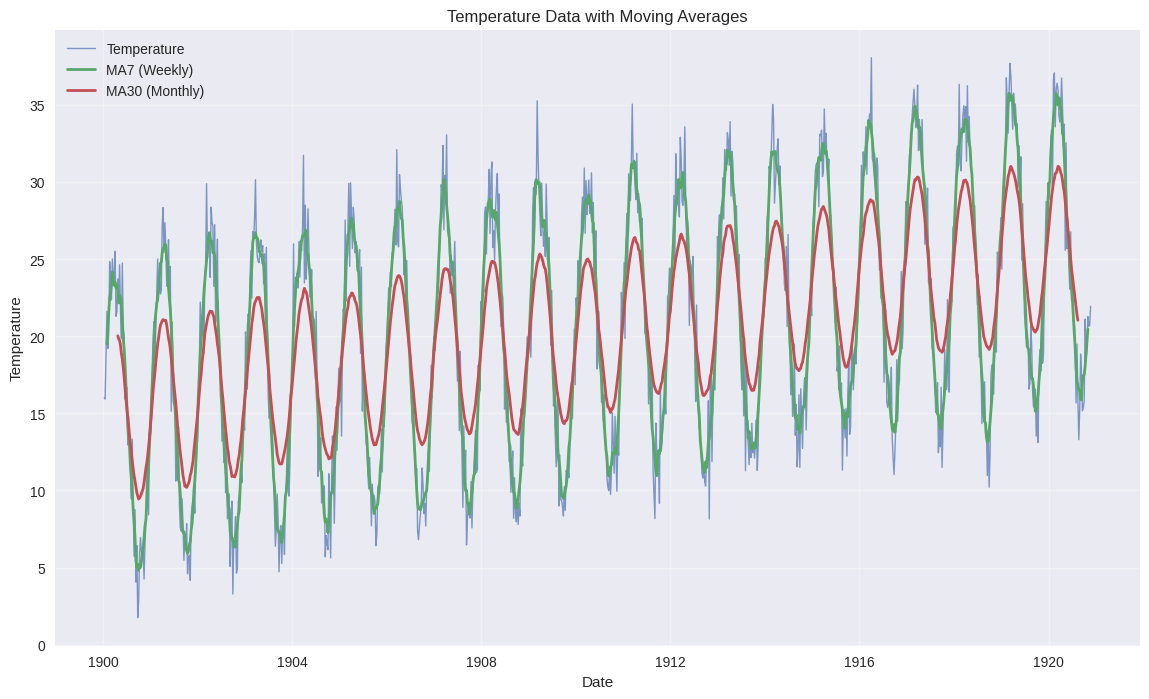

In [3]:
# Create moving averages to smooth the data
def moving_average(series, window):
    return series.rolling(window=window, center=True).mean()

ma7 = moving_average(temp_df, 7)   # Weekly moving average
ma30 = moving_average(temp_df, 30)  # Monthly moving average

# Plot original data with moving averages
plt.figure(figsize=(14, 8))
plt.plot(temp_df.index, temp_df, label='Temperature', alpha=0.7, linewidth=1)
plt.plot(temp_df.index, ma7, label='MA7 (Weekly)', linewidth=2)
plt.plot(temp_df.index, ma30, label='MA30 (Monthly)', linewidth=2)
plt.title('Temperature Data with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

MA30 is too smooth but MA7 works nicely.

Now, we take seasonality, trend, and cycle into account with functions from forecast. Essentially, we are finding all the sources of variance from our observations. You can actually see quite a lot just from this too.

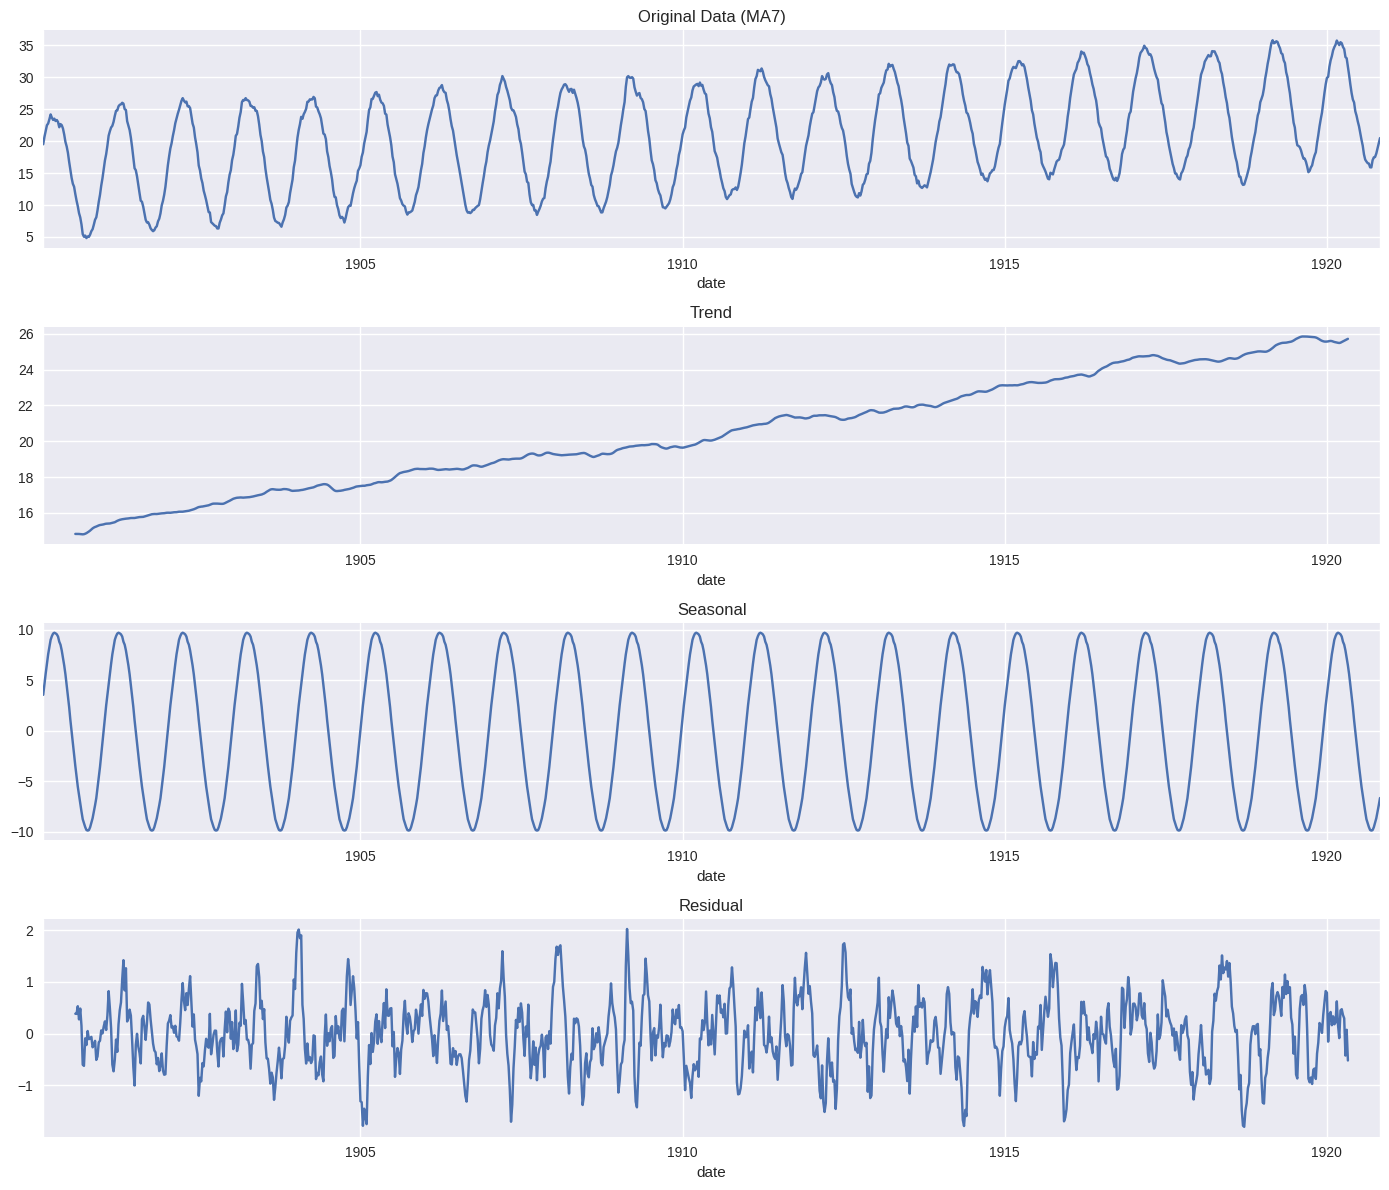


Decomposition components:
- Original: The weekly moving average data
- Trend: Long-term movement in the data
- Seasonal: Repeating seasonal patterns (52-week cycle)
- Residual: Remaining variation after removing trend and seasonality


In [4]:
# safeguarding for blanks
ma7 = ma7.dropna()

# Perform seasonal decomposition. For weekly data, we assume 52 weeks per year
decomposition = seasonal_decompose(ma7, model='additive', period=52)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
decomposition.observed.plot(ax=axes[0], title='Original Data (MA7)')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

# Remove seasonal component
deseasonal_data = ma7['temp']-decomposition.seasonal.values

print("\nDecomposition components:")
print("- Original: The weekly moving average data")
print("- Trend: Long-term movement in the data")
print("- Seasonal: Repeating seasonal patterns (52-week cycle)")
print("- Residual: Remaining variation after removing trend and seasonality")

Finding a good ARIMA Model

Remember a model is defined as ARIMA(p, d, q) where:
*   p	=	how many past observations are considered to affect the current observation (using PCAF, last lag spike)
*   d	=	degree of differencing involved (using ADF then differencing [1  3  5 becomes 2  2, which is a single degree of differencing])
*   q	=	order of the moving average part (ACF, last lag spike).



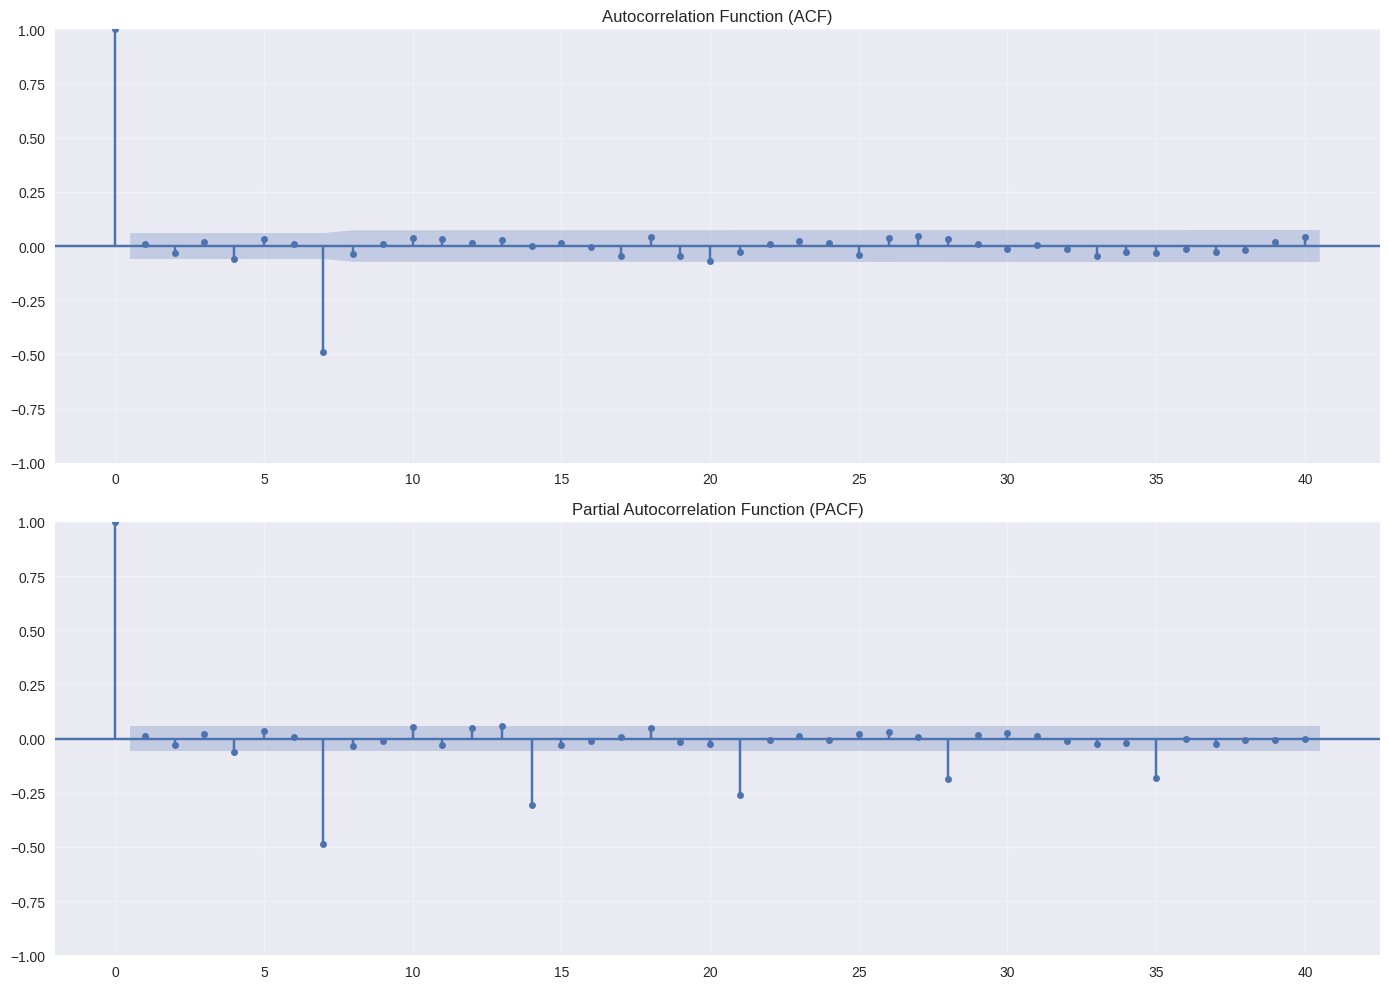


p=35

d=1

d=20


In [5]:
# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    # Perform ADF test
    result = adfuller(timeseries.dropna())
    return result[1] <= 0.05  # Returns true if stationary

diff_value = 0  # this is the "d" value
is_stationary = check_stationarity(deseasonal_data)
deseasonal_diff = deseasonal_data.copy()

while not is_stationary:
    # If not stationary, apply differencing
    if not is_stationary and diff_value <= 3:
        deseasonal_diff = deseasonal_diff.diff().dropna()
        diff_value += 1
        is_stationary = check_stationarity(deseasonal_diff)
    else:
        break

# Plot ACF and PACF to determine p and q parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ACF plot
plot_acf(deseasonal_diff.dropna(), ax=ax1, lags=40, title='Autocorrelation Function (ACF)')
ax1.grid(True, alpha=0.3)

# PACF plot
plot_pacf(deseasonal_diff.dropna(), ax=ax2, lags=40, title='Partial Autocorrelation Function (PACF)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate ACF and PACF values and use them to find significant lags where values exceed approximate 95% confidence bounds
acf_values = acf(deseasonal_diff.dropna(), nlags=40)
pacf_values = pacf(deseasonal_diff.dropna(), nlags=40)
n = len(deseasonal_diff.dropna())
confidence_bound = 1.96 / np.sqrt(n) # Rule of thumb, this works to give 95% confidence because maths.
significant_acf_lags = []
significant_pacf_lags = []

for i in range(1, len(acf_values)):
    if abs(acf_values[i]) > confidence_bound:
        significant_acf_lags.append(i)  # last one will be "q" value

for i in range(1, len(pacf_values)):
    if abs(pacf_values[i]) > confidence_bound:
        significant_pacf_lags.append(i)  # last one will be "p" value

print(f"\np={significant_pacf_lags[len(significant_pacf_lags)-1]}")
print(f"\nd={diff_value}")
print(f"\nd={significant_acf_lags[len(significant_acf_lags)-1]}")

We now fit our ARIMA Model, and we can check its accuracy by holding some data back and showing prediction vs actual.

Fitting a model takes a WHILE.

In [6]:
# Create Holdout
holdout_size = 100
train_data = deseasonal_diff.dropna()[:-holdout_size]
test_data = deseasonal_diff.dropna()[-holdout_size:]

# Fit manual ARIMA model on the training data
p_manual = significant_pacf_lags[len(significant_pacf_lags)-1]
q_manual = significant_acf_lags[len(significant_acf_lags)-1]
arima_model = ARIMA(train_data, order=(p_manual, diff_value, q_manual))
arima_fit = arima_model.fit()

# Forecast from fitted model
forecast_res = arima_fit.get_forecast(steps=holdout_size)
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()


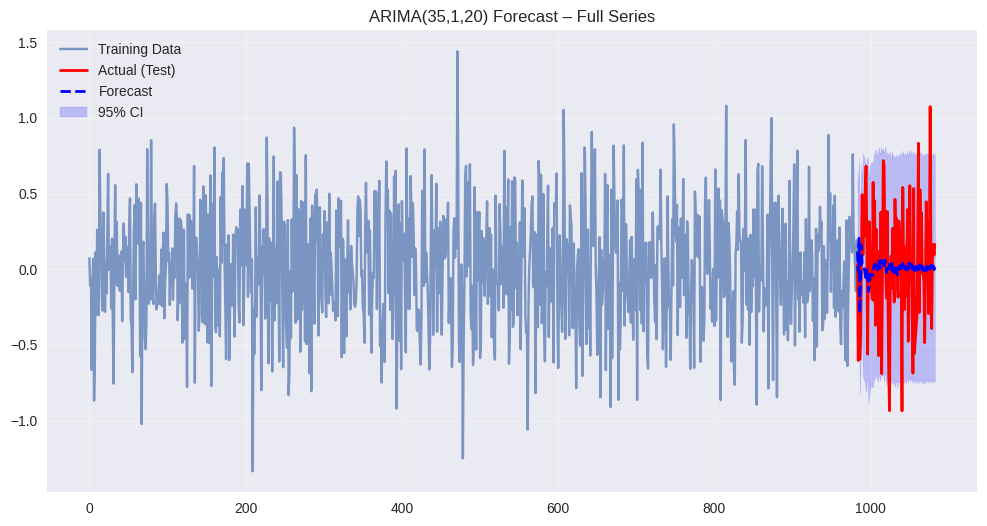

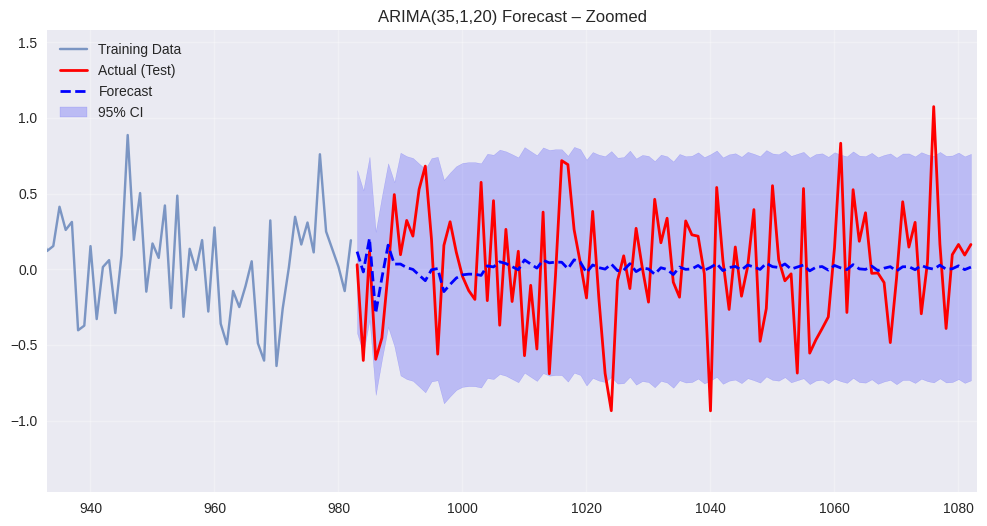

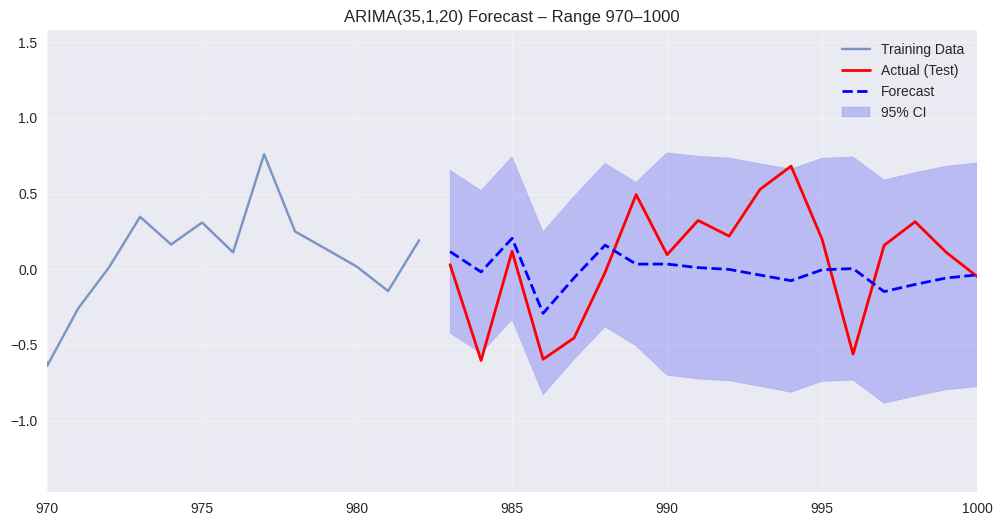

In [7]:
# Common x-ranges
train_end = len(train_data)
test_range = range(train_end, train_end + holdout_size)

# --- 1. Full series plot ---
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, label='Training Data', alpha=0.7)
plt.plot(test_range, test_data, label='Actual (Test)', color='red', linewidth=2)
plt.plot(test_range, forecast, label='Forecast', color='blue', linewidth=2, linestyle='--')
plt.fill_between(test_range, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='blue', alpha=0.2, label='95% CI')
plt.title(f'ARIMA({p_manual},{diff_value},{q_manual}) Forecast – Full Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 2. Zoomed-in plot (train_end - 50 to end of holdout) ---
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, label='Training Data', alpha=0.7)
plt.plot(test_range, test_data, label='Actual (Test)', color='red', linewidth=2)
plt.plot(test_range, forecast, label='Forecast', color='blue', linewidth=2, linestyle='--')
plt.fill_between(test_range, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='blue', alpha=0.2, label='95% CI')
plt.xlim(train_end - 50, train_end + holdout_size)
plt.title(f'ARIMA({p_manual},{diff_value},{q_manual}) Forecast – Zoomed')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. Focused on 970–1000 ---
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, label='Training Data', alpha=0.7)
plt.plot(test_range, test_data, label='Actual (Test)', color='red', linewidth=2)
plt.plot(test_range, forecast, label='Forecast', color='blue', linewidth=2, linestyle='--')
plt.fill_between(test_range, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='blue', alpha=0.2, label='95% CI')
plt.xlim(970, 1000)
plt.title(f'ARIMA({p_manual},{diff_value},{q_manual}) Forecast – Range 970–1000')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Adhoc Prediction**

In [10]:
steps_ahead = int(input("Enter number of periods to predict ahead: "))

forecast_result = arima_fit.get_forecast(steps=steps_ahead)
prediction = forecast_result.predicted_mean.iloc[-1]  # Get the final prediction
conf_int = forecast_result.conf_int().iloc[-1]  # Get confidence interval for final prediction

print(f"\nPrediction for {steps_ahead} periods ahead:")
print(f"Predicted value: {prediction:.2f}")
print(f"95% Confidence your value will be between: {conf_int[0]:.2f} and  {conf_int[1]:.2f}")

seasonal_avg = decomposition.seasonal.mean()  # Average seasonal component
adjusted_prediction = prediction + seasonal_avg
print(f"Seasonally adjusted prediction: {adjusted_prediction:.2f}")

Enter number of periods to predict ahead: 1

Prediction for 1 periods ahead:
Predicted value: 0.12
95% Confidence your value will be between: -0.42 and  0.65
Seasonally adjusted prediction: 0.13
